In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

# Load the CSV file
data = pd.read_csv('data/merged_file.csv')  # We're only interested in Job_Title and Job_Details columns
data = data[['Job_Title', 'Job_Details']]   # Preprocess the job details (filling any missing values)
data['Job_Details'] = data['Job_Details'].fillna('')    # TF-IDF Vectorization for job details

data


,Job_Title,Job_Details
0,Lab Analyst - C4I WISE,ACTIVE DOD CLEARANCE REQUIRED\nPosition Title:...
1,Healthcare Data Analyst II-Health Services Eva...,What You Can You Expect!\n\nFind joy in servin...
2,Laboratory Data and Inspection Analyst (Associ...,The California Department of Public Health (CD...
3,IT Data Analyst,"We make good investments in our people, proper..."
4,Board Certified Behavioral Analyst- San Diego ...,Board Certified Behavioral Analyst- San Diego ...
...,...,...
1462,Controls / Automation Engineer,Title: Automation / Controls Engineer\nPositio...
1463,Visualization Engineer (Unity),"We are a small, growing team and value those w..."
1464,Senior Software Engineer,Software Resources has an immediate job opport...
1465,"Principal Software Engineer, ADAS Compute Plat...",Job Description\nIf you are a Principal S oftw...


In [ ]:
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['Job_Details']).toarray() # We can use the Job_Title as our target label, converting it into a numeric form

# Define the LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Job_Title'])  # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Define a basic Neural Network model in TensorFlow

# Define the model
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))  # Predict job titles based on job details

# Evaluate the model
predictions = model.predict(X_test)
predicted_job_titles = label_encoder.inverse_transform(predictions.argmax(axis=1))  # Example: Print one prediction and its corresponding job description
for i in range(5):
    print(f"Predicted Job Title: {predicted_job_titles[i]}")
    print(f"Job Description: {data['Job_Details'].iloc[i]}\n")  # Save the model for later use
model.save('resume_generator_model.h5')

## Clustering Analysis
The PCA algorithm is used to reduce the dimensionality of the data, and the elbow method and silhouette score are used to determine the optimal number of clusters.
Our elbow method and silhouette score plots are shown below:

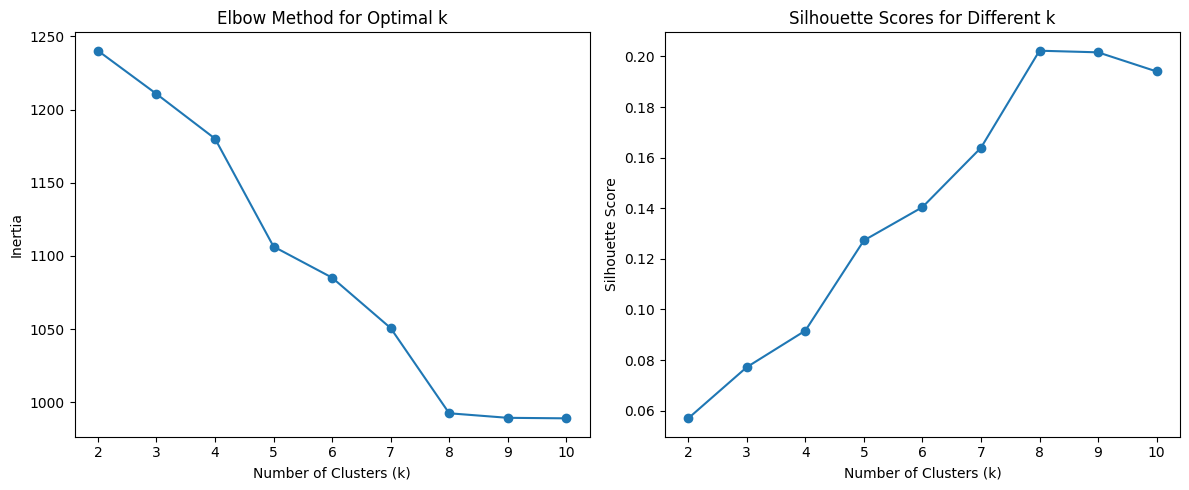

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Determine optimal number of clusters using Elbow Method and Silhouette Score
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualize Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.tight_layout()
plt.show()


In [6]:
# Choose optimal number of clusters based on the plots
optimal_k = 5  # Adjust this value based on your analysis

# Perform K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

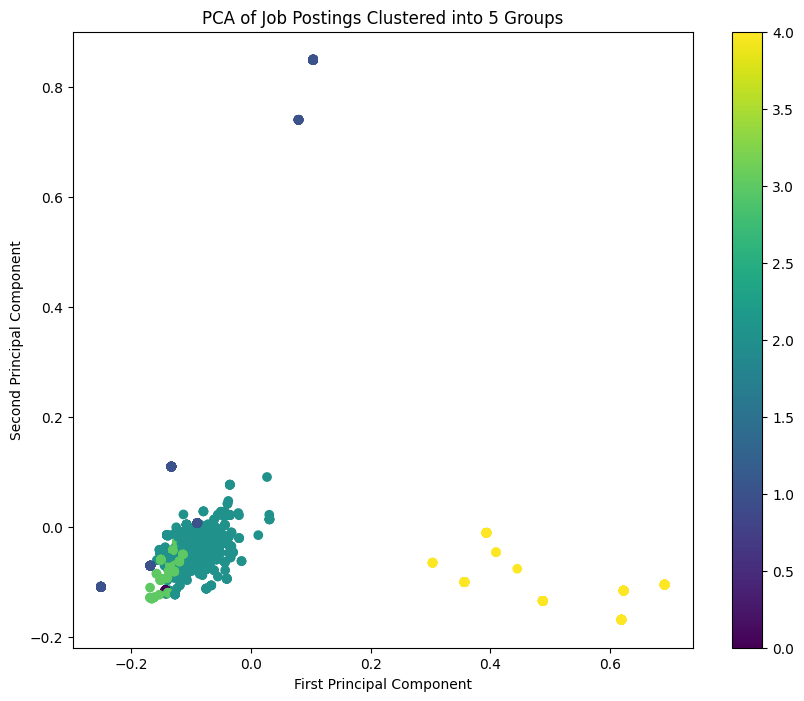


Clustering Analysis Findings:
1. Optimal number of clusters: 5
2. Each cluster represents a group of job postings with similar skills and qualifications.
3. The PCA visualization shows how these clusters are distributed in a 2D space.

Cluster 0:
Number of jobs: 31
Top job titles:
Job_Title
Medicine - Artificial Intelligence Faculty    31
Name: count, dtype: int64

Most common words:
and             589
of              279
to              279
in              279
the             248
or              155
with            155
that            155
Cedars-Sinai    155
for             124
Name: count, dtype: int64

Cluster 1:
Number of jobs: 277
Top job titles:
Job_Title
Software Engineer                   79
Visualization Engineer (Unity)      60
Sr. Software Developer              56
Landing Page Developer/Designer     36
Software Engineer Manager C++ C#    35
Name: count, dtype: int64

Most common words:
and         6078
to          2702
of          2407
in          2395
the         2282
a 

In [7]:
# Visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'PCA of Job Postings Clustered into {optimal_k} Groups')
plt.show()

# Documentation and Analysis
print("\nClustering Analysis Findings:")
print(f"1. Optimal number of clusters: {optimal_k}")
print("2. Each cluster represents a group of job postings with similar skills and qualifications.")
print("3. The PCA visualization shows how these clusters are distributed in a 2D space.")

# Analyze clusters
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    words = cluster_text.split()
    word_freq = pd.Series(words).value_counts()
    print(word_freq.head(10))

print("\nInsights gained from unsupervised learning:")
print("1. The job market can be segmented into distinct groups based on required skills and qualifications.")
print("2. Some clusters may represent specific job categories or industries.")
print("3. The distribution of job titles within each cluster can reveal trends in job market demand.")
print("4. Common words in each cluster can highlight the key skills and qualifications for different job categories.")
print("5. This clustering can help in tailoring resumes for specific job clusters or identifying emerging job categories.")



## Word Cloud Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Shows the most common keywords, helping identify focus areas in the resume.
We removed stopwords from the word cloud to improve readability. 

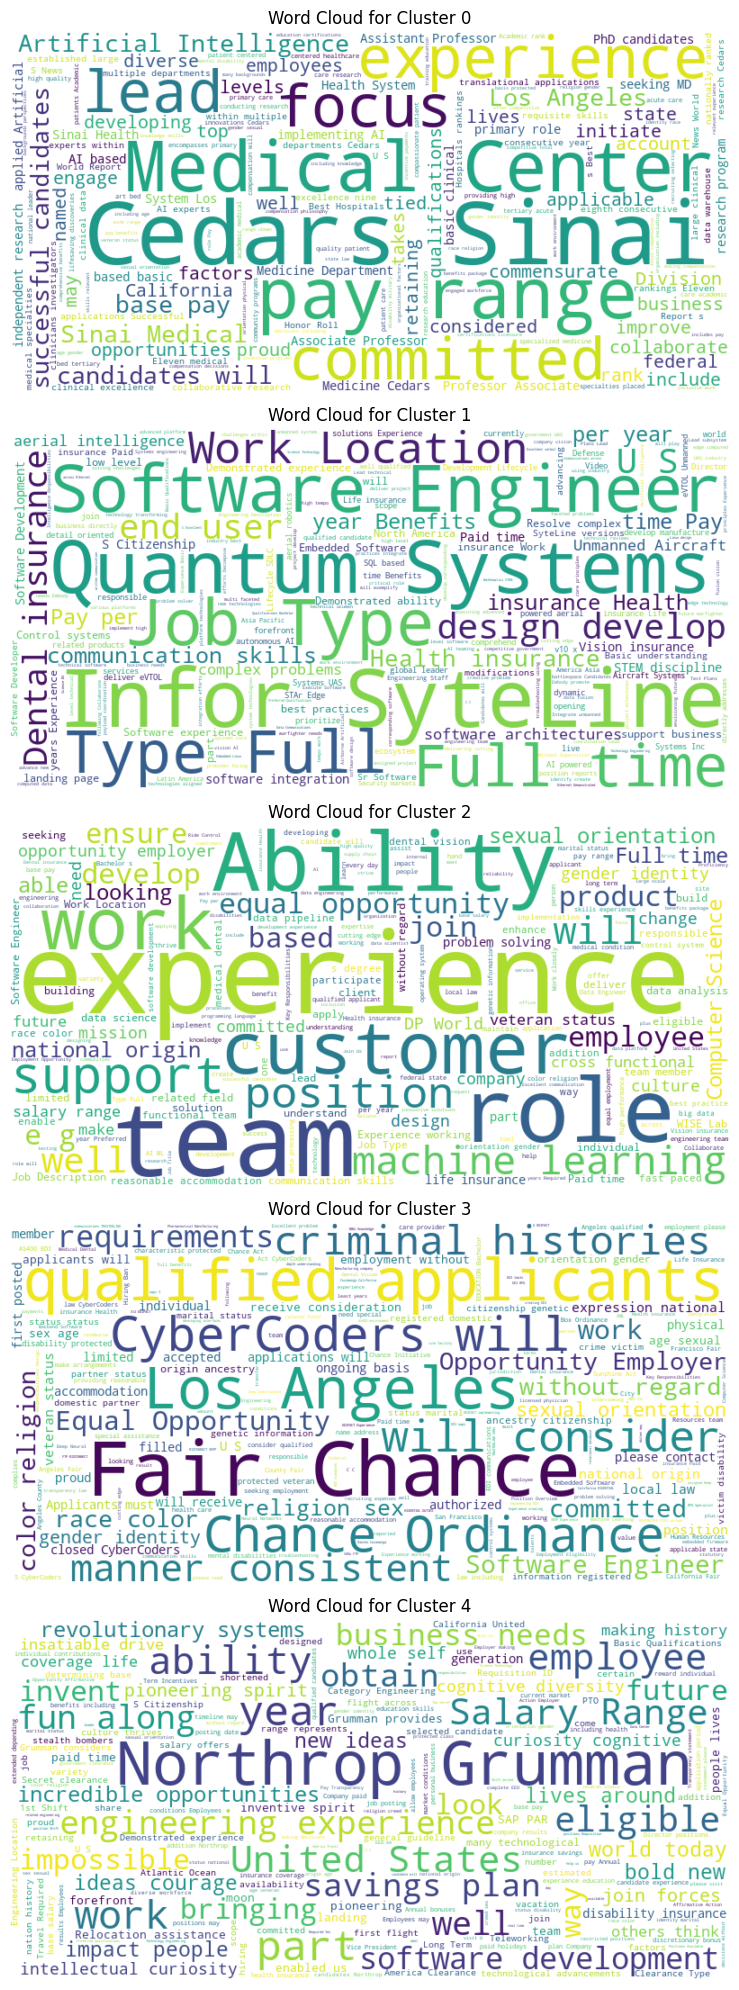

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for each cluster
plt.figure(figsize=(20, 4 * optimal_k))
stopwords = set(STOPWORDS)  # Add predefined stop words

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Generate the word cloud with stopwords removed
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(cluster_text)
    
    plt.subplot(optimal_k, 1, cluster + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


## Bar Plot Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Compare keyword usage in the resume vs. job descriptions to spot alignment gaps.

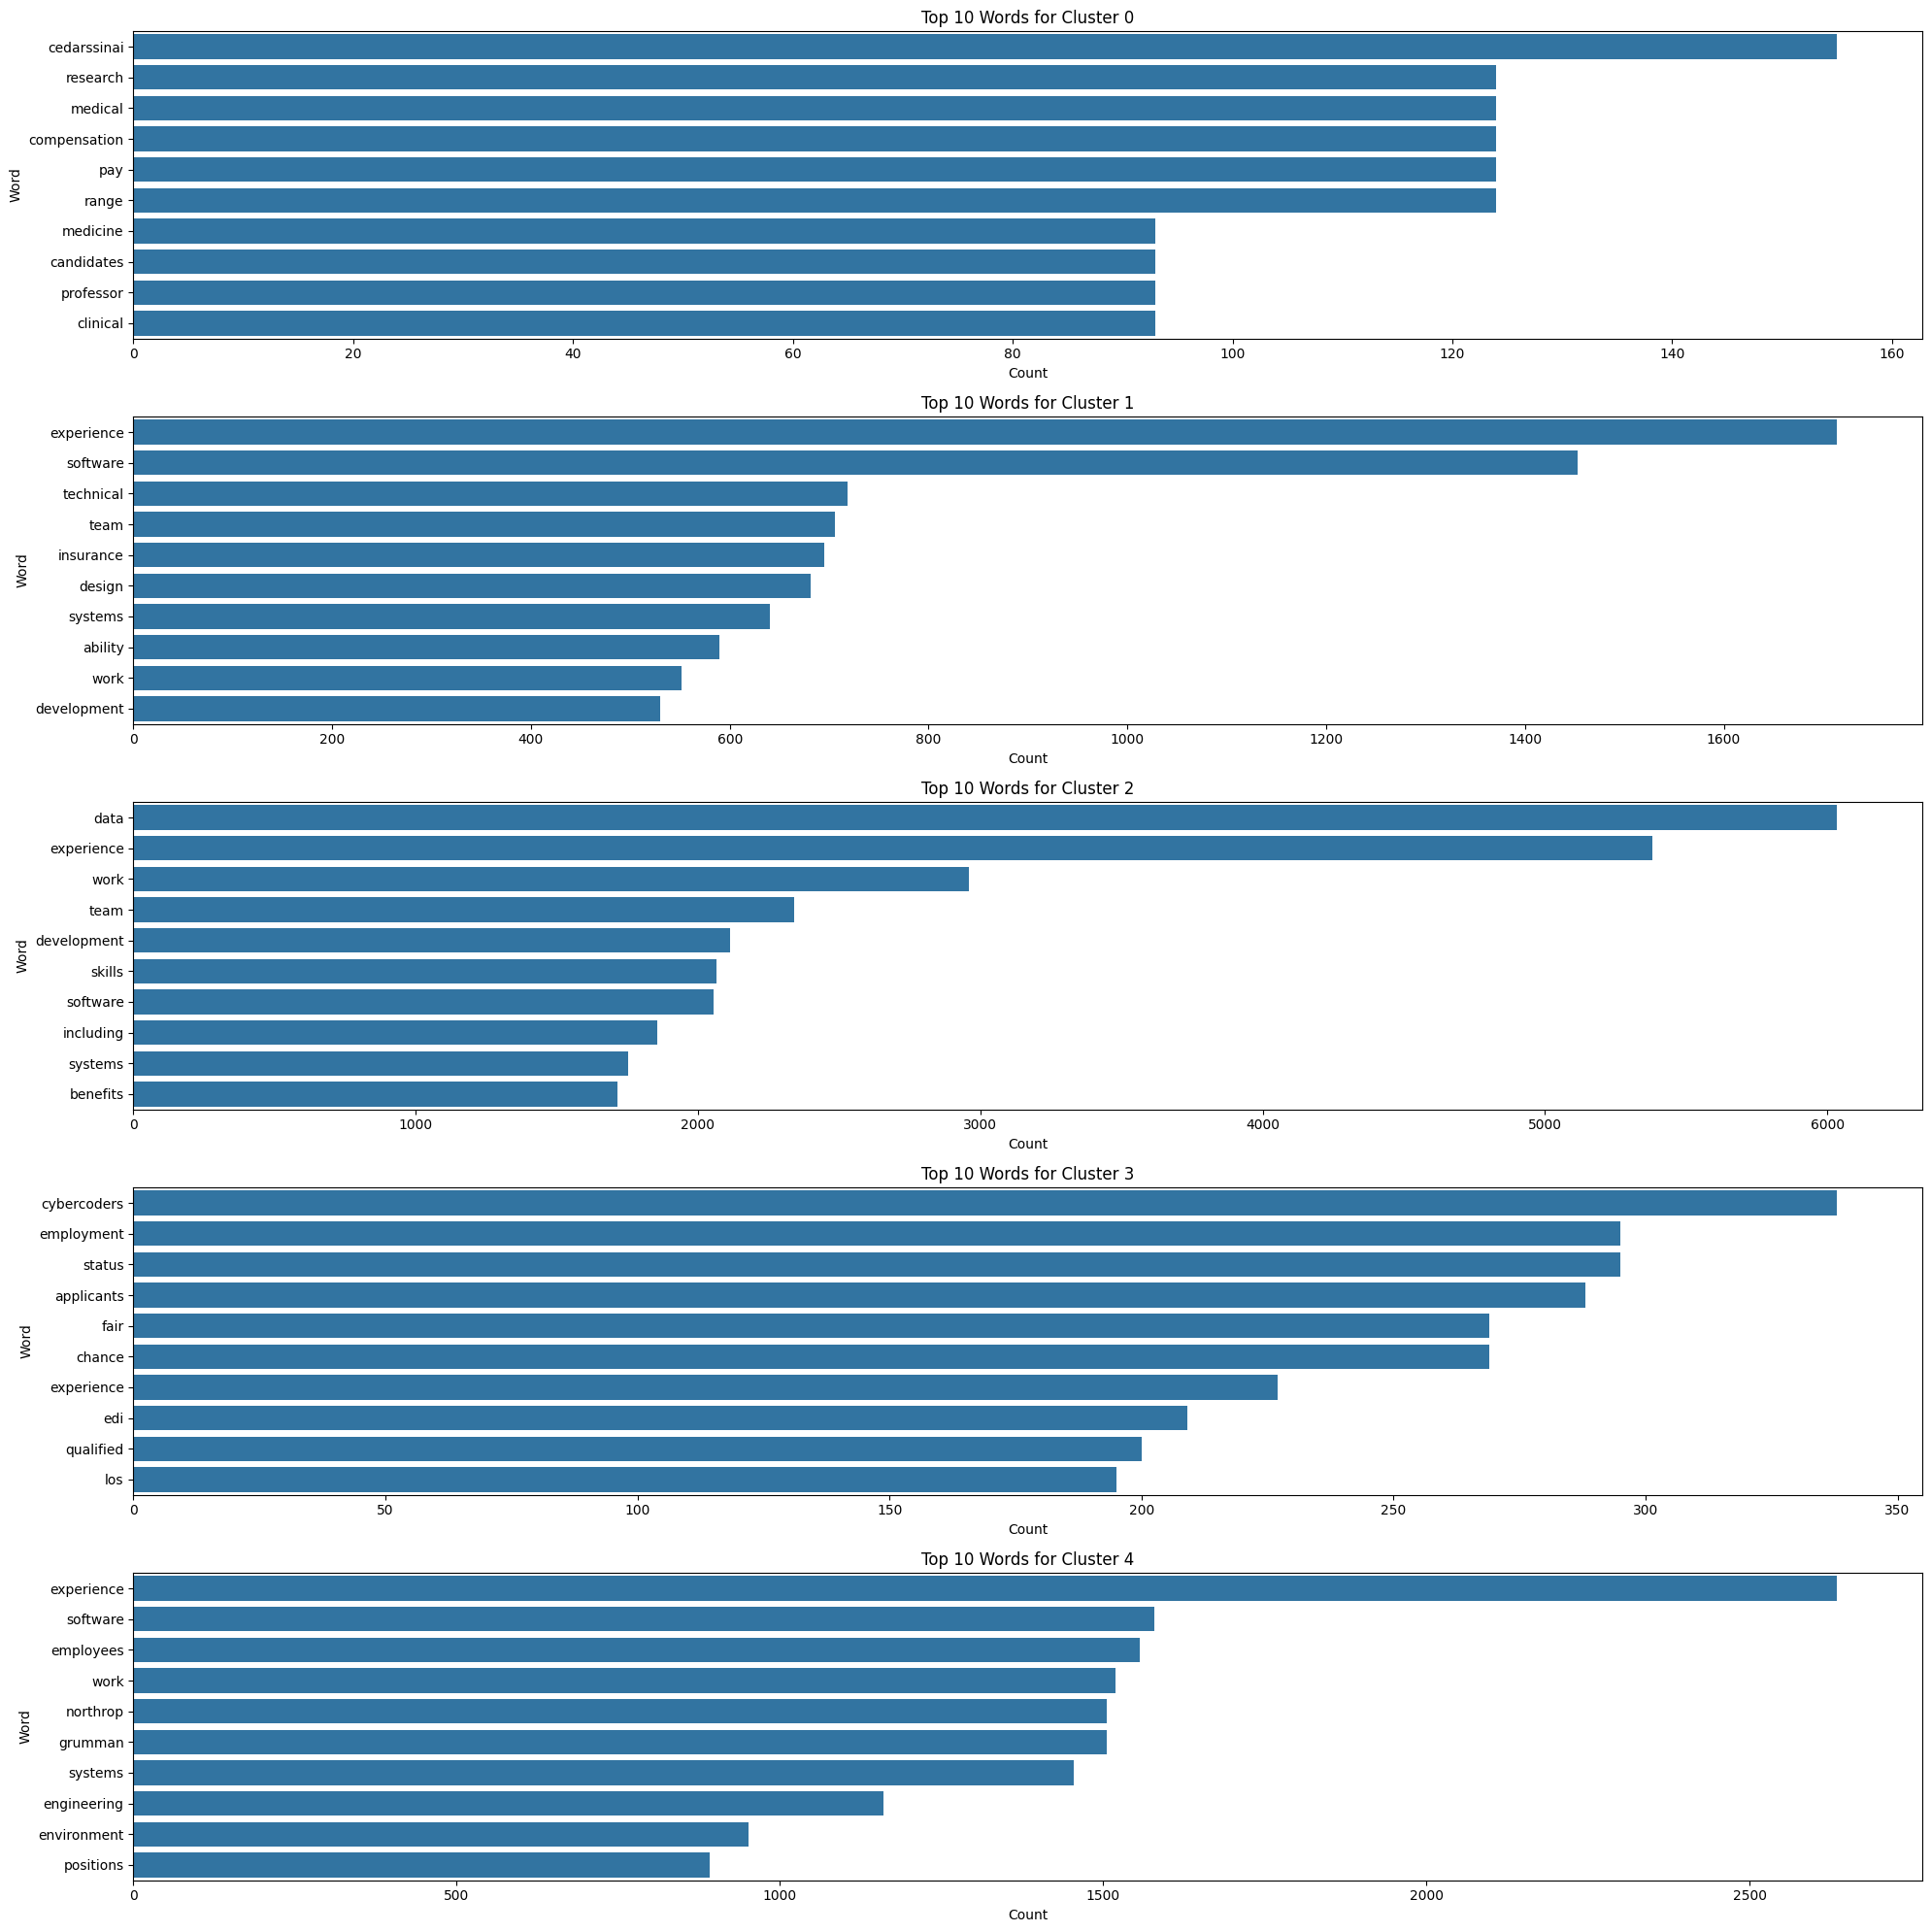

In [12]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

# Function to get top N words, excluding stop words and punctuation
def get_top_words(text, n=10):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words
    words = text.split()
    
    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    
    # Count words
    word_counts = Counter(words)
    return dict(word_counts.most_common(n))

# Create a plot for each cluster
plt.figure(figsize=(20, 4*optimal_k))

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Get top 10 words
    top_words = get_top_words(cluster_text)
    
    # Create a DataFrame for seaborn
    word_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Count'])
    
    # Create subplot
    plt.subplot(optimal_k, 1, cluster+1)
    
    # Create bar plot using seaborn
    sns.barplot(x='Count', y='Word', data=word_df, orient='h')
    
    plt.title(f'Top 10 Words for Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()


In [13]:
# Print cluster analysis
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    top_words = get_top_words(cluster_text, n=10)
    for word, count in top_words.items():
        print(f"{word}: {count}")



Cluster 0:
Number of jobs: 31
Top job titles:
Job_Title
Medicine - Artificial Intelligence Faculty    31
Name: count, dtype: int64

Most common words:
cedarssinai: 155
research: 124
medical: 124
compensation: 124
pay: 124
range: 124
medicine: 93
candidates: 93
professor: 93
clinical: 93

Cluster 1:
Number of jobs: 277
Top job titles:
Job_Title
Software Engineer                   79
Visualization Engineer (Unity)      60
Sr. Software Developer              56
Landing Page Developer/Designer     36
Software Engineer Manager C++ C#    35
Name: count, dtype: int64

Most common words:
experience: 1714
software: 1453
technical: 718
team: 706
insurance: 695
design: 681
systems: 640
ability: 590
work: 551
development: 530

Cluster 2:
Number of jobs: 861
Top job titles:
Job_Title
Data Engineer                                                                      25
Lab Analyst - C4I WISE                                                             22
Laboratory Data and Inspection Analyst (Assoc